In [1]:
from matplotlib import pyplot
import matplotlib
matplotlib.rcParams['font.size'] = 16
import numpy
import random
import math

Matplotlib is building the font cache; this may take a moment.


# Inference

### Peter Onyisi

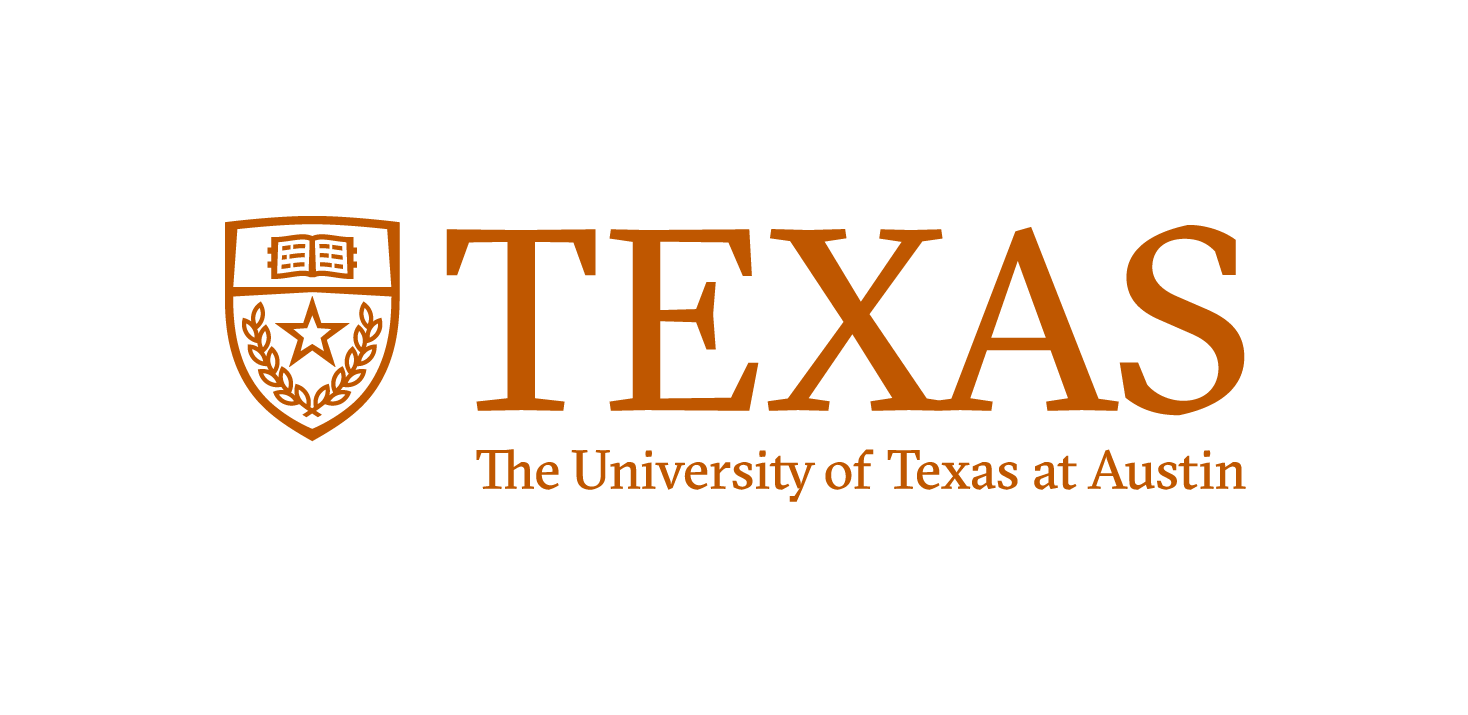

## Introduction

We are often interested in trying to determine the parameters of some assumed probability distribution, given some observed data.

Simple example: if we have a set of measurements that we assume came from a Gaussian distribution, what are the mean and standard deviation of that distribution?

More complicated example: from a set of electronic signals recorded by the ATLAS detector, what is the rate of Higgs boson production (this being a Poisson process)?

These are termed "inference" problems - we are trying to infer something unobservable (the "true" parameters) from observations.  This involves finding "estimators" which are functions of observed data that estimate the parameters.

**CAUTION**: there is a lot of very fancy math which can tell you about how to get model parameters from observed data. It doesn't tell you how to avoid choosing a bad model in the first place - in that situation all bets are off as to what parameters you will get.  Unfortunately, since we rarely know the exact model that produced observed data, there's usually some uncertainty arising from this.  (In other words: "with enough data all models fail".)

## Maximum Likelihood

An intuitive approach (and one that is extremely common in practice) is to find what parameters make the observed data "most likely".  To be more rigorous, assuming the observed data $\{x_i\}$ are independent samplings from a probability density/mass function $P$, we want to maximize the _likelihood function_
$$ \mathcal{L}(\{x_i\}; \theta) = \prod_i P(x_i ; \theta) $$
where $\theta$ represent the parameters (there may be several of them, e.g. the mean and standard deviation of a Guassian).  We find the _best-fit_ parameters by maximizing $\mathcal{L}$:
$$ \frac{\partial\mathcal{L}}{\partial \theta} = 0 $$
In practice generally we want to avoid dealing with very large or small numbers, so we actually use the logarithm of the likelihood, and for technical reasons we usually _minimize_ rather than maximize functions. So in fact we are usually dealing minimizing
$$-\ln\mathcal{L}(\{x_i\}; \theta) = -\sum_i \ln P(x_i ; \theta) $$
which will give the same $\theta$ values.

As an aside: we normally think of the PDFs as functions of the observables, with fixed parameters.  The likelihood inverts this: the data points are fixed (they are what we observed), and the parameters change.

## Maximum Likelihood: analytic example

From some data $\{x_i\}$ that we believe to have been generated from a Gaussian distribution, let us determine what the maximimum likelihood estimators (MLE) for the mean and standard deviation of the Gaussian are.

First, we write the $-\ln\mathcal{L}$ function:
$$ -\ln\mathcal{L} = -\sum_i \ln G(x_i; \mu, \sigma) = -\sum_i \left[- \frac{1}{2}\ln 2\pi - \ln \sigma - \frac{(x_i - \mu)^2}{2\sigma^2}\right]$$
To obtain $\hat\mu$, which is our estimate of $\mu$, requre $\partial(-\ln \mathcal{L})/\partial \mu = 0$ when evaluated at $\hat\mu$:
$$ 0 = \left.\frac{\partial(-\ln \mathcal{L})}{\partial \mu}\right|_{\mu=\hat\mu} = \sum_i \frac{x_i - \hat \mu}{\sigma^2} $$
Since $\sigma^2$ is constant in this example, this is solved with $\sum_i (x_i - \hat \mu) = 0$, or 
$$ \hat \mu = \frac{1}{N} x_i $$
so the maximum likelihood estimator of the Gaussian mean is the mean of the observations. (Makes sense.)

For the standard deviation estimator $\hat \sigma$, we do a similar thing:
$$ 0 = \left.\frac{\partial(-\ln \mathcal{L})}{\partial \sigma}\right|_{\sigma=\hat\sigma} = \sum_i \frac{1}{\hat \sigma} - \frac{(x_i - \mu)^2}{\hat\sigma^3} $$
with the solution
$$ \hat \sigma = \sqrt{\frac{1}{N}\sum_i (x_i - \mu)^2} $$
which is the root-mean-square.

Now here we have a little bit of an ambiguity.  If we _know_ what $\mu$ is, then we can just plug that in.  If we _don't_ know what $\mu$ is, then we need to use $\hat\mu$ instead, and _simultaneously_ determine $\hat\mu$ and $\hat\sigma$ (i.e. while we can determine $\hat\mu$ without determining $\hat\sigma$, the reverse isn't true).  

Using the estimated $\hat\mu$ instead of the real $\mu$ when determining $\hat \sigma$ has an effect which we will take a look at shortly: basically, you've used a piece of information to get $\hat\mu$, so your estimate of $\hat\sigma$ is biased.  (Imagine you have only one observation. If you know the real $\mu$, you can make an estimate of the standard deviation with just that one measurement.  However if you don't know $\mu$, your best guess for it is that one observation, and then you have no idea what the real $\sigma$ is, and the estimator $\hat \sigma$ will always be zero! You can get an unbiased estimator for $\sigma$ by using $N-1$ in the denominator instead of $N$, but this is no longer the MLE.)  However the MLE is "consistent" - for large data sample sizes, it will converge to the correct value.

Mean muhat: 0.0002305592366196715
Mean sigmahat: 0.9994568466434557


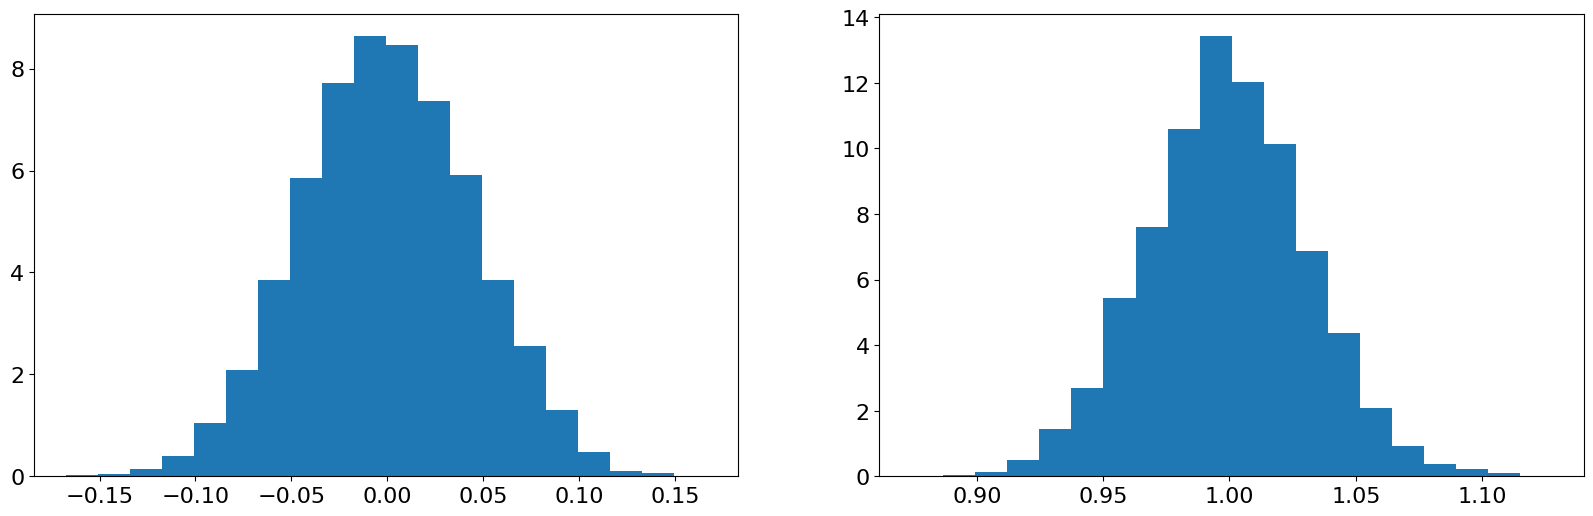

In [2]:
# Generate some Gaussian-distributed samples, compute MLE for mean and sigma
muhatresults = []
sigmahatresults = []
Nsamples=5000
Nmeasurements=500
for i in range(Nsamples):
    measurements = numpy.random.normal(loc=0., scale=1., size=Nmeasurements)
    muhat = sum(measurements)/Nmeasurements
    sigmahat = math.sqrt(sum((measurements-muhat)**2)/(Nmeasurements))
    muhatresults.append(muhat)
    sigmahatresults.append(sigmahat)
    
pyplot.figure(figsize=(20,6))
pyplot.subplot(1,2,1)
pyplot.hist(muhatresults, bins=20, density=True)
pyplot.subplot(1,2,2)
pyplot.hist(sigmahatresults, bins=20, density=True)
pyplot.draw()
print('Mean muhat:', sum(muhatresults)/Nsamples)
print('Mean sigmahat:', math.sqrt(sum(sigmahatresults)/Nsamples))

## Estimating Estimator Error

If we have only one set of measurements and we get an estimator of a parameter from them, we would like to know how different from the true value the estimator might be.  (In fact an estimator is a random variable, with a PDF!)  From the previous example, we see that the estimator $\hat\mu$ for a Gaussian distribution starts to take on a Gaussian distribution itself for quite small data sample sizes, and it turns out that $\hat\sigma$ will also begin to be Gaussian-distributed if $N$ is large enough.

We can imagine that the shape of the likelihood function gives an indication of how well the parameter is estimated: it could be that a large range of parameters are "almost as likely" to produce the observed data as the best-fit value.  Let's look at the log likelihood function from the Gaussian example:

$$ -\ln\mathcal{L} = -\sum_i \left[- \frac{1}{2}\ln 2\pi - \ln \sigma - \frac{(x_i - \mu)^2}{2\sigma^2}\right]$$

We can plot it for a single set of data $\{x_i\}$ and see what we get.  We need to make a 2D plot though, since although $\hat\mu$ doesn't depend on $\sigma$, in general $-\ln\mathcal{L}$ does.

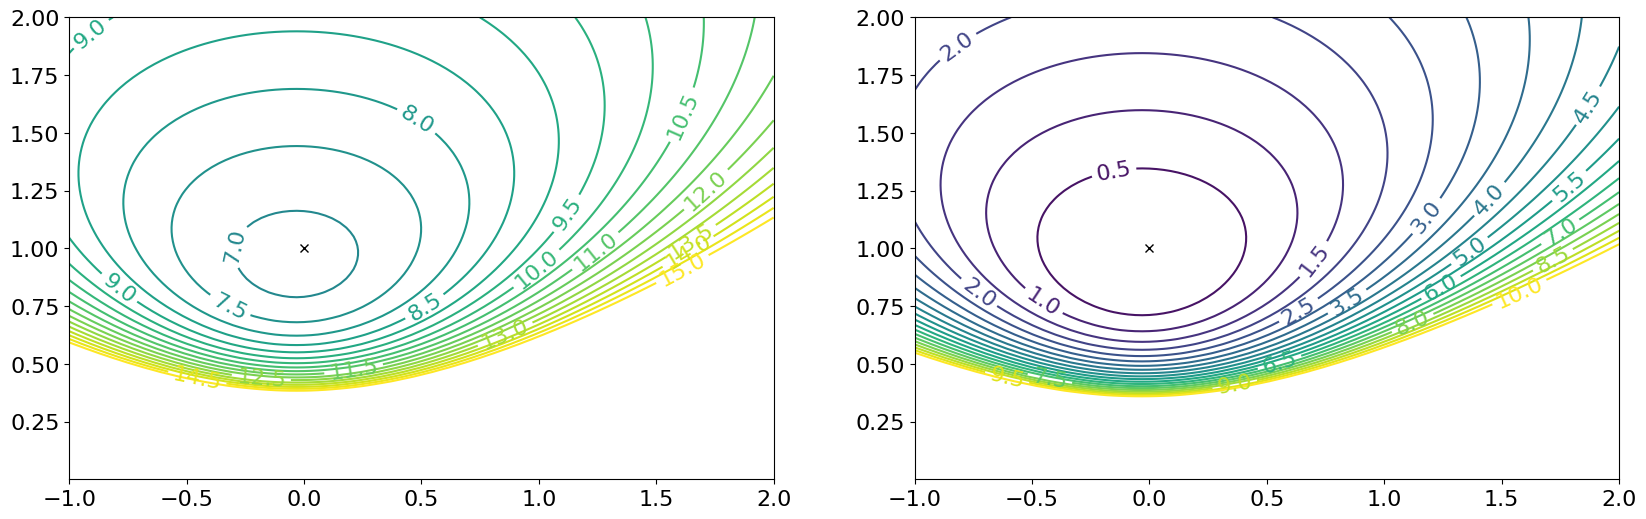

In [3]:
# thrown from a unit Gaussian (mean=0, standard deviation=1)
data = numpy.array([-0.63683437,  0.62146476, -0.07712931, -1.38964153,  1.32031845])
def gaus_negloglikelihood(mu, sigma, data):
    # the random coefficient is 0.5*ln(2pi)
    return len(data)*(0.9189385332046727+math.log(sigma)) + sum((data-mu)**2)/(2*sigma*sigma)

pyplot.figure(figsize=(20,6))
pyplot.subplot(1,2,1)
X, Y = numpy.meshgrid(numpy.linspace(-1, 2, 100), numpy.linspace(0.00001, 2, 100))
func_proj = lambda a, b: gaus_negloglikelihood(a, b, data)
Z = numpy.array(numpy.frompyfunc(func_proj, 2, 1)(X, Y), dtype='float32')

# for z in Z:
#     print(numpy.array(z, dtype='f'))
#     if ~numpy.isfinite(numpy.array(z, dtype='d')):
#         print(z)
# print(X, Y, type(Z), numpy.linspace(0,15,31))
# plot = pyplot.contour(X, Y, Z)

plot = pyplot.contour(X, Y, Z, levels=numpy.linspace(0,15,31))
pyplot.clabel(plot)
pyplot.plot(0, 1, 'x', color='k')

# compute delta to minimum (shift minimum to zero)
pyplot.subplot(1,2,2)
muhat = sum(data)/len(data)
sigmahat = math.sqrt(sum((data-muhat)**2)/len(data))
minll = gaus_negloglikelihood(muhat, sigmahat, data)
Z -= minll
plot = pyplot.contour(X, Y, Z, levels=numpy.linspace(0,10,21))
pyplot.clabel(plot)
pyplot.plot(0, 1, 'x', color='k')
pyplot.draw()

Let's look at the distribution of $-\Delta\ln\mathcal{L}$ between the true parameter and the best-fit point, over a number of experimental samples. (Actually, for technical reasons, let's look at $-2\Delta\ln\mathcal{L}$.)

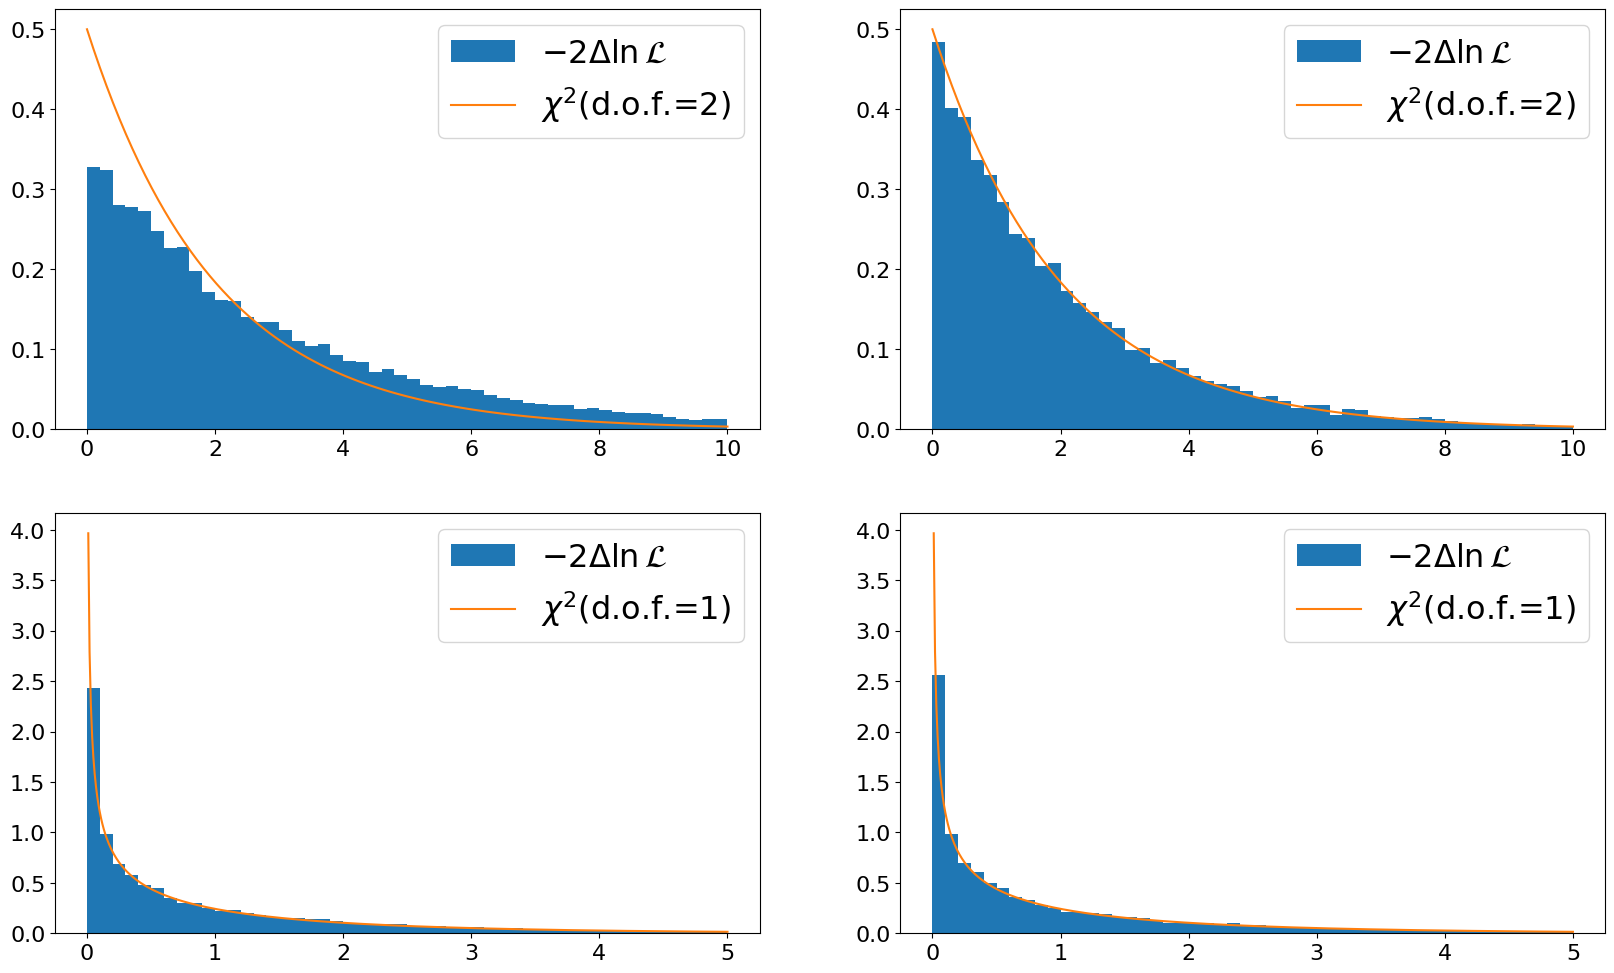

In [4]:
def generatedeltall(Nsamples, Nmeasurements, fixmu=None, fixsigma=None):
    deltallresults = []
    for i in range(Nmeasurements):
        data = numpy.random.normal(size=Nsamples)
        muhat = numpy.sum(data)/len(data) if fixmu is None else fixmu
        sigmahat = math.sqrt(numpy.sum((data-muhat)**2)/len(data)) if fixsigma is None else fixsigma
        deltall = gaus_negloglikelihood(0, 1, data)-gaus_negloglikelihood(muhat, sigmahat, data)
        deltallresults.append(2*deltall)
    return deltallresults
    
pyplot.figure(figsize=(20,12))
pyplot.subplot(2,2,1)
pyplot.hist(generatedeltall(3, 20000), density=True, bins=50, range=(0,10), label=r'$-2\Delta\ln\mathcal{L}$')
from scipy.stats import chi2
pyplot.plot(numpy.linspace(0,10,100), chi2.pdf(numpy.linspace(0,10,100), 2), label=r'$\chi^2$(d.o.f.=2)')
pyplot.legend(fontsize='x-large')

pyplot.subplot(2,2,2)
pyplot.hist(generatedeltall(20, 20000), density=True, bins=50, range=(0,10), label=r'$-2\Delta\ln\mathcal{L}$')
from scipy.stats import chi2
pyplot.plot(numpy.linspace(0,10,100), chi2.pdf(numpy.linspace(0,10,100), 2), label=r'$\chi^2$(d.o.f.=2)')
pyplot.legend(fontsize='x-large')

# for the following, we fix either mu or sigma (reducing d.o.f. by 1)
pyplot.subplot(2,2,3)
pyplot.hist(generatedeltall(5, 20000, fixmu=0), density=True, bins=50, range=(0,5), label=r'$-2\Delta\ln\mathcal{L}$')
from scipy.stats import chi2
pyplot.plot(numpy.linspace(0,5,500), chi2.pdf(numpy.linspace(0,5,500), 1), label=r'$\chi^2$(d.o.f.=1)')
pyplot.legend(fontsize='x-large')

pyplot.subplot(2,2,4)
pyplot.hist(generatedeltall(5, 20000, fixsigma=1), density=True, bins=50, range=(0,5), label=r'$-2\Delta\ln\mathcal{L}$')
from scipy.stats import chi2
pyplot.plot(numpy.linspace(0,5,500), chi2.pdf(numpy.linspace(0,5,500), 1), label=r'$\chi^2$(d.o.f.=1)')
pyplot.legend(fontsize='x-large')

pyplot.draw()

## Wilks' Theorem

For large sample sizes, the probability distribution of $-2\Delta\ln\mathcal{L} \equiv -2\left(\ln\mathcal{L}(\{x_i\}, \theta_\mathrm{true})-\ln\mathcal{L}(\{x_i\}, \theta_\mathrm{best-fit}) \right)$, approaches a constant family of functions, the $\chi^2$ distributions (with the number of degrees of freedom of the number of parameters you are determining).

This means we can compute the probability that $-2\Delta\ln\mathcal{L}$ will be smaller than a certain value: this lets us specify an uncertainty on the estimator. (This can be computed with `scipy.stats.chi2.ppf`.)

| Probability that $-2\Delta\ln\mathcal{L}<Z$ | Z (1 d.o.f.) | Z (2 d.o.f.) |
| -- | -- | -- |
| 68.2% | 1.0 | 2.3 |
| 90% | 2.7 | 4.6 |
| 95.4% | 4 | 6.2 |

The "standard error bars" (also called "1 sigma" errors, or "68% confidence level", CL) correspond to 68.2% probability.  So we would say that values of the parameters for which $-2\Delta\ln\mathcal{L}$ is smaller than the corresponding Z value for the number of adjustable parameters are "1&sigma; consistent with the result".

**CAREFUL**: you should not interpret a 68% CL range as meaning "the true parameter has a 68% probability of being in this range".  What the "68% CL" means is "we have followed a proceedure in which, starting from a true value of the parameter, the quoted range will include the true value of the parameter in 68% of the cases".  In a bit we will discuss frequentist versus Bayesian interpretation, which makes this difference explicit.

## Profile likelihood

Sometimes we construct a likelihood function with many parameters where we are only really interested in one of them (or a few).  For example, it is extremely common today to consider systematic uncertainties in an analysis as parameters in a likelihood function.  One can include a PDF for the distribution of the value of the systematic uncertainty (e.g. a Gaussian where the mean is set to the nominal value of the uncertain parameter) or allow it to "float" (equivalently, have a badly-normalized, uniform PDF).  The maximum likelihood fit is then essentially measuring all the systematic uncertainty parameters simultaneously with the parameters we are really interested in.  Putting a PDF on the systematic uncertainties prevents the fit from considering "unlikely" values of the systematics. For reasons which will become clearer later these PDFs on the systematics are often called "priors".

The parameters that you actually are interested in are typically called "parameters of interest" (POI) and the others are called "nuisance parameters".  Let's consider a likelihood function with POI $\delta$ and nuisance parameters $\xi$. One can perform a trick to extract the POI without having to consider the full complexity of the model: instead of considering the distribution of the likelihood function in all parameters, you define a new _profile likelihood_ function $L_p$ of the $\delta$ only and  _marginalize_ over the $\xi$:  
$$L_p(\delta) = \max_\xi \mathcal{L}(\{x_i\}, \delta, \xi)$$
That is, the profile likelihood function is defined as the maximum likelihood possible for a given choice of POI, allowing all nuisance parameters to vary.  The maximum of $L_p$ is also the maximum of $\mathcal{L}$, so we can determine the $\delta_\mathrm{best-fit}$ by maximizing $L_p$ (minimizing $-\ln L_p$).  

What's nice about $L_p$ is that it provides a natural way to determine the effect of systematic uncertainties on a POI. Let's consider a toy example, where we make $N$ measurements $\{x_i\}$, with a known uncorrelated measurement uncertainty $\sigma$ on each measurement, and we want to determine their mean. The measurement apparatus might be miscalibrated, so all the measurements could be wrong by a common additive term $\xi$, which we will assume is "distributed like a Gaussian with standard deviation $\sigma_\xi$." 

(Aside: what it means for this systematic error, which presumably has a specific value, to be distributed according to a PDF is a philosophical one, but it's a reasonable reminder that systematic uncertainty estimation is an art as much as a science.  Sometimes there are good reasons to choose a specific PDF, e.g. if the uncertainty is actually the statistical uncertainty from an auxiliary measurement. Frequentists and Bayesians have arguments about this but it's really not worth the trouble.)

Then the full likelihood function is given by 
$$\begin{eqnarray}\mathcal{L}&=&\left[\prod_i \exp(-(x_i - (\mu + \xi))^2/2\sigma^2)\right]\exp(-\xi^2/2\sigma_\xi^2)\\
-\ln\mathcal{L} &=& \frac{\xi^2}{2\sigma_\xi^2} + \sum_i \frac{(x_i - (\mu + \xi))^2}{2\sigma^2}\end{eqnarray}$$
To compute $-\ln L_p$ we take $\partial(-\ln\mathcal{L})/\partial \xi$, set it to zero for a given $\mu$, and solve for $\hat\xi$ (the maximizing value of $\xi$):
$$ \hat\xi(\mu) = \left(\frac{\sum_i x_i}{N} - \mu\right)\frac{1}{1+(\sigma^2/N)/\sigma_\xi^2}$$
This result makes sense: if the data prefer a higher mean than what we are assuming ($\sum_i x_i/N > \mu$) then we will also favor that $\xi > 0$. If $\sigma/\sqrt{N}$ - which is the statistical uncertainty on $\mu$ - is large compared to $\sigma_\xi$, then the fit favors not moving $\xi$ very much from zero, and rather treating the difference between $\sum_i x_i/N$ and $\mu$ as coming from a statisical fluctuation.  If $\sigma/\sqrt{N}$ is much smaller than $\sigma_\xi$, then the fit will say that the difference between $\sum_i x_i/N$ and $\mu$ must come entirely from a non-zero $\xi$.

We then define $-\ln L_p(\mu) = -\ln\mathcal{L}(\{x_i\}, \mu, \hat\xi)$.  We find
$$ -2\ln L_p(\mu) = \frac{\sum_i(\mu-x_i)^2}{\sigma^2} - \frac{N}{\sigma^2}\left(\mu-\frac{\sum_i x_i}{N} \right)^2\frac{1}{1+\sigma^2/N\sigma_\xi^2}$$
Let's see how this works out in practice (evaluating $-2\Delta \ln L_p$):

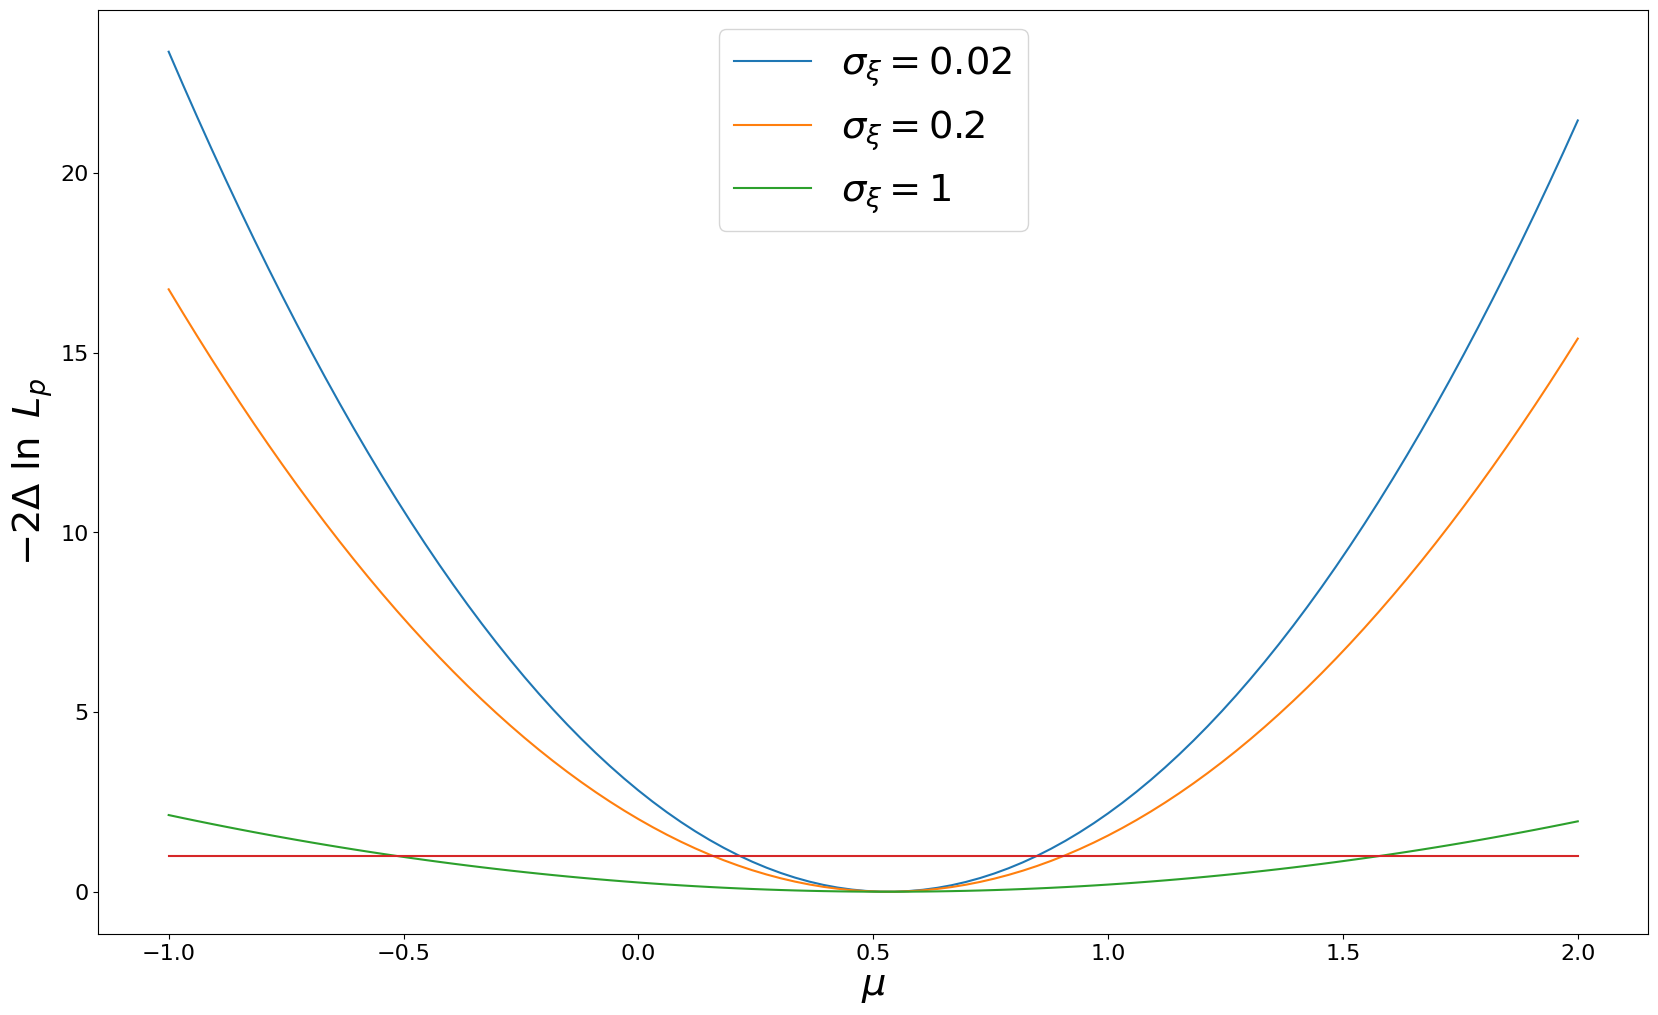

In [5]:
def loglp(mu, data, sigma, sigmaxi):
    return (1/sigma**2)*(sum((data-mu)**2) - len(data)*(sum(data)/len(data) - mu)**2/(1+sigma**2/len(data)/sigmaxi**2))

def minloglp(mu, data, sigma, sigmaxi):
    return loglp(sum(data)/len(data), data, sigma, sigmaxi)

numpy.random.seed(2019)
data = numpy.random.normal(loc=0., scale=1., size=10)

xvals = numpy.linspace(-1,2,100)
pyplot.figure(figsize=(20,12))
yvals = [loglp(x, data, 1., 0.02)-minloglp(x, data, 1, 0.02) for x in xvals]
pyplot.plot(xvals, yvals, label=r'$\sigma_\xi = 0.02$')
yvals = [loglp(x, data, 1., 0.2)-minloglp(x, data, 1, 0.2) for x in xvals]
pyplot.plot(xvals, yvals, label=r'$\sigma_\xi = 0.2$')
yvals = [loglp(x, data, 1., 1)-minloglp(x, data, 1, 1) for x in xvals]
pyplot.plot(xvals, yvals, label=r'$\sigma_\xi = 1$')
pyplot.plot(xvals, [1]*len(xvals))
pyplot.legend(fontsize='xx-large')
pyplot.ylabel(r'$-2\Delta\ \ln\ L_p$', fontsize='xx-large')
pyplot.xlabel(r'$\mu$', fontsize='xx-large')
pyplot.show()

In this case, the $-2\Delta\ln L_p = 1$ points can be shown to lie at $\hat\mu \pm \sqrt{\sigma^2/N+\sigma_\xi^2}$. In the limit that $\sigma_\xi$ is very small (the systematic uncertainty is negligible compared to the statistical uncertainty), then this reduces to $\pm \sigma/\sqrt{N}$, which we would expect. Otherwise, it is the statistical and systematic uncertainties added in quadrature, as we might naively expect from error propagation.

The following plots are examples of a 1-parameter (top) and 2-parameter (bottom) scan of parameter values in a Higgs boson analysis at the ATLAS experiment.  The top shows $-2\Delta \ln \mathcal{L}$ (here called $-2\ln\Lambda$) for the overall Higgs boson production rate ($\mu=1$ is the theory prediction of the particle physics Standard Model).  The bottom shows two parameters that would alter certain Higgs boson interactions; different sets of events collected by ATLAS are sensitive to different combinations of the parameters.  68% confidence level regions are shown for the individual studies; the combination of all the studies together is indicated in black with both 68% and 95% contours.

![1D scan](https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/HIGG-2018-57/fig_01.png)
![2D scan](https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/HIGG-2018-57/fig_12.png)

(Note: the likelihood for the combination is obtained as $\ln\mathcal{L}_\mathrm{comb} = \sum_i \ln\mathcal{L}_i$ for all specific studies $i$.)

## The Bayes Theorem Problem

*Question*: Suppose I have developed a test for a disease. For people who have the disease, it correctly identifies this 99% of the time.  For people who do not have the disease, it incorrectly claims that they have the disease 2% of the time. For someone who tests positive, what is the probability that they actually have the disease?

*Answer*: This isn't enough information to know!

*Longer answer*: We might be tempted to construct a likelihood function (it's kind of a simple one, since the variables are discrete, but it's still well-defined).  We would say: given the data (a positive test), then
$$\mathcal{L}(\textrm{positive test},\textrm{disease status}) = \left\{\begin{array}{l} 0.99,\textrm{ person has disease}\\ 0.02,\textrm{ person does not have disease}\end{array}\right. $$
($\mathcal{L}$ does not integrate to 1, but this is not surprising, likelihood functions are not required to do so.) The maximum likelihood estimator would say that a positive test implies the person has the disease, and we might be tempted to "renormalize" the likelihood, say, and assign the probability $0.99/(0.99+0.02)$ to this statement.

This is not actually good logic.  Let's say that only 0.1% of the population actually has the disease, and we've just randomly selected a person to take the test.  Then we find:

|Situation | Probability |
|--|--|
|Person does not have disease, tests negative | 0.999 x 0.98 = 0.979 |
|Person does not have disease, tests positive | 0.999 x 0.02 = 0.020 |
|Person has disease, tests positive | 0.001 x 0.99 = 0.001 |
|Person has disease, tests negative | 0.001 x 0.01 = 0.00001 |

From this, it is twenty times more likely that a person who tests positive actually does not have the disease than that they do! 

The origin of the issue (aka the _prosecutor's fallacy_) is that a likelihood function is not a probability distribution, even if it is derived from them.  It is better to think of the likelihood as a way of encoding the _information gain_ or _evidence_ from a measurement or experiment.  So, in this example, if a person tests positive, it may not be the case that they _do_ have the disease, but the _chances that they do_, compared to the general population, has increased quite a bit (from 0.1% to 4.8%). 

The general formula for the probability that $A$ is true given observations $\{x_i\}$ and a likelihood function $\mathcal{L}(\{x_i\}, X)$ is given by "Bayes's Formula":

$$ P(A | \{x_i\}) = \frac{ \mathcal{L}(\{x_i\}, A) P(A)}{\sum_X \mathcal{L}(\{x_i\}, X) P(X)} $$

The "overall" probability $P(A)$ of $A$ being true before the test is called a _prior_, as it reflects prior knowledge about a situation.  The likelihood therefore takes you from the prior probability distribution to the _posterior_ $P(A | \{x_i\})$ which reflects what you know after the measurement.

So far, so good. But what if you don't know what the prior distribution is? There are two approaches to this...

* **"Frequentist"**: you avoid the question of priors entirely, instead essentially reporting the properties of the likelihood (or whatever statistical test is being used).  In the disease test example, a frequentist would be restricted to saying "your test was positive. The test returns a result correctly corresponding to whether you have the disease 98% of the time or better."  Because priors are avoided, *frequentist statements never give the probability of a hypothesis being true*; by construction, they cannot.  In my personal opinion they have a tendency to provide precisely defined answers to questions that aren't actually the ones you want.
* **"Bayesian"**: you have to assume a prior, and then you report the posterior (which is now fully interpretable as a probability).  What prior do you choose? In some cases, you may have a good motivation to pick one (for example, you have previous measurements which give you indications).  When you don't, you will be stuck arguing about the prior; popular choices are "flat" (uniform in the parameters) or "uninformative" (derived to satisfy various mathematical properties). Clearly, in this case assuming a flat prior - a 50%-50% chance that the person has the disease - would give a wild overestimate of the probability that the person does have the disease, so Bayesian constructions can fail badly if the priors are wrong.

In practice, most physicists (and people) are Bayesians: we do, at some level, want to know the probability that something is true (does the Higgs boson exist?) rather than properties of statistical tests (if the Higgs boson did not exist, how likely would it be that we see the peaks we do?).  The fact that almost everyone rejected the superluminal neutrino result from OPERA, in spite of it having high significance, is related to this point: our priors were so strongly against faster-than-light movement that it overrode the evidence from the experiment. Generally particle physicists try to force themselves into the frequentist framework, partially because frequentist procedures don't have a subjective component in the same way that Bayesian ones do, and partially because Bayesian methods can be quite complicated if the priors are non-trivial.  (Cosmology has long been much more comfortable with Bayesian procedures, which are standard.)

In my opinion the only place where this is really a significant issue is when a test/measurement is weak in some way. In the disease test example, if the test is improved so that the false positive rate is a factor of a thousand less, then 98% of positive tests will be accurate - a significant improvement - and it doesn't matter much if 0.1% or 1% of the population actually have the disease, whereas this would have mattered a lot with the original test.  In other words, a good measurement has a likelihood function that is so highly peaked around the correct answer that it can overcome all reasonable priors that can be proposed.  If the priors matter, it's a strong indication that you should be taking the result with caution: it will have useful information, but will generally not be conclusive on its own.

## What is a 95% confidence level upper limit?

A frequentist concept...

The _standard_ 95% CL upper limit on a parameter $\theta$ means: 
* you have constructed a "test statistic" which distinguishes a non-zero $\theta$ from a zero value, for example, a likelihood ratio of the best-fit $\hat\theta$ to the proposed $\theta$
$$q_\theta = \left\{ \begin{array}{l} -2\ln \frac{\mathcal{L}(\{x_i\}, \theta)}{\mathcal{L}(\{x_i\}, \hat\theta)} , \ \hat\theta < \theta \\ 0,\ \hat\theta \ge \theta\end{array}\right.$$
(Note that conventionally the signal is taken as the _null_ hypothesis! So $q_\theta$ increases as $\theta=0$ more accurately describes the data)
* given the observed data, you determine the largest $\theta$ such that $q_\theta$ larger than observed would only occur 5% of the time ($p$-value = 0.05)

In other words, a 95% CL upper limit is the largest number where a downward fluctuation to what is observed would be more than 5% probable.

There is an alternative which is universal for ATLAS and CMS results called the _CLs upper limit_.  This attempts to remedy the fact that a "poor" experiment, with large background compared to signal, could report an "excessively good" upper limit if there was a downward fluctuation of the background yield.  For example:

| Experiment | mean background | mean signal for $\theta=1$ | median 95% CL UL on $\theta$ |
| -- | -- | -- | -- |
| "Good" | 0.1 | 1 | 2.9 |
| "Bad" | 10 | 2 | 3.5 |

(the UL is determined as the 95% CL upper limit on the total number of observed events, minus the mean background, divided by the mean $\theta=1$ signal.)

So far, so good. But it is not possible to see less than zero events in the "Good" experiment, so the best UL that can be achieved is 2.9.  In the "Bad" experiment, if we observe only 8 events, we will get a 95% CL upper limit of $\theta$ = 2.2, which is better than the "Good" experiment!  In fact, if we observed only 4 events in the "Bad" experiment, we wouldn't be able to set an upper limit at all, because even with zero signal, a background of 10 events doesn't fluctuate down to 4 events or fewer more than 5% of the time.  (This is compensated by the "Bad" experiment getting much worse limits half of the time.)

In [6]:
from scipy.stats import poisson
from scipy.optimize import root_scalar

def standardCLpoiss(obs):
    root = root_scalar(lambda mu: poisson.cdf(obs, mu)-0.05, bracket=[0, 5*(max(obs,1))], method='brenth')
    if not root.converged: raise Exception("Root not found...")
    return root.root

def get_median_theta(bkg, signal):
    data = numpy.random.poisson(bkg, size=500)
    limits = numpy.frompyfunc(standardCLpoiss, 1, 1)(data)
    return (numpy.median(limits)-bkg)/signal

print('Good experiment median theta limit', get_median_theta(0.1, 1))
print('Bad experiment median theta limit', get_median_theta(10, 2))
print('95% UL on theta, bad experiment, 8 events', (standardCLpoiss(8)-10)/2)
print('95% UL on theta, bad experiment, 4 events', (standardCLpoiss(4)-10)/2)
print(standardCLpoiss(40)/40)

Good experiment median theta limit 2.895732273553769
Bad experiment median theta limit 3.481109617860918
95% UL on theta, bad experiment, 8 events 2.2173248575981557
95% UL on theta, bad experiment, 4 events -0.4232404866812125
1.3017342278784247


To try to compensate for this in a somewhat ad hoc way, the CLs limit was introduced.  This penalizes the experimental result if it would be unlikely under the no-signal hypothesis.  The 95% CLs upper limit is defined as the smallest $\theta$ for which the probability of seeing a result as extreme as observed, divided by the probability of seeing a result as extreme as observed for the $\theta=0$ hypothesis, is less than 5%.

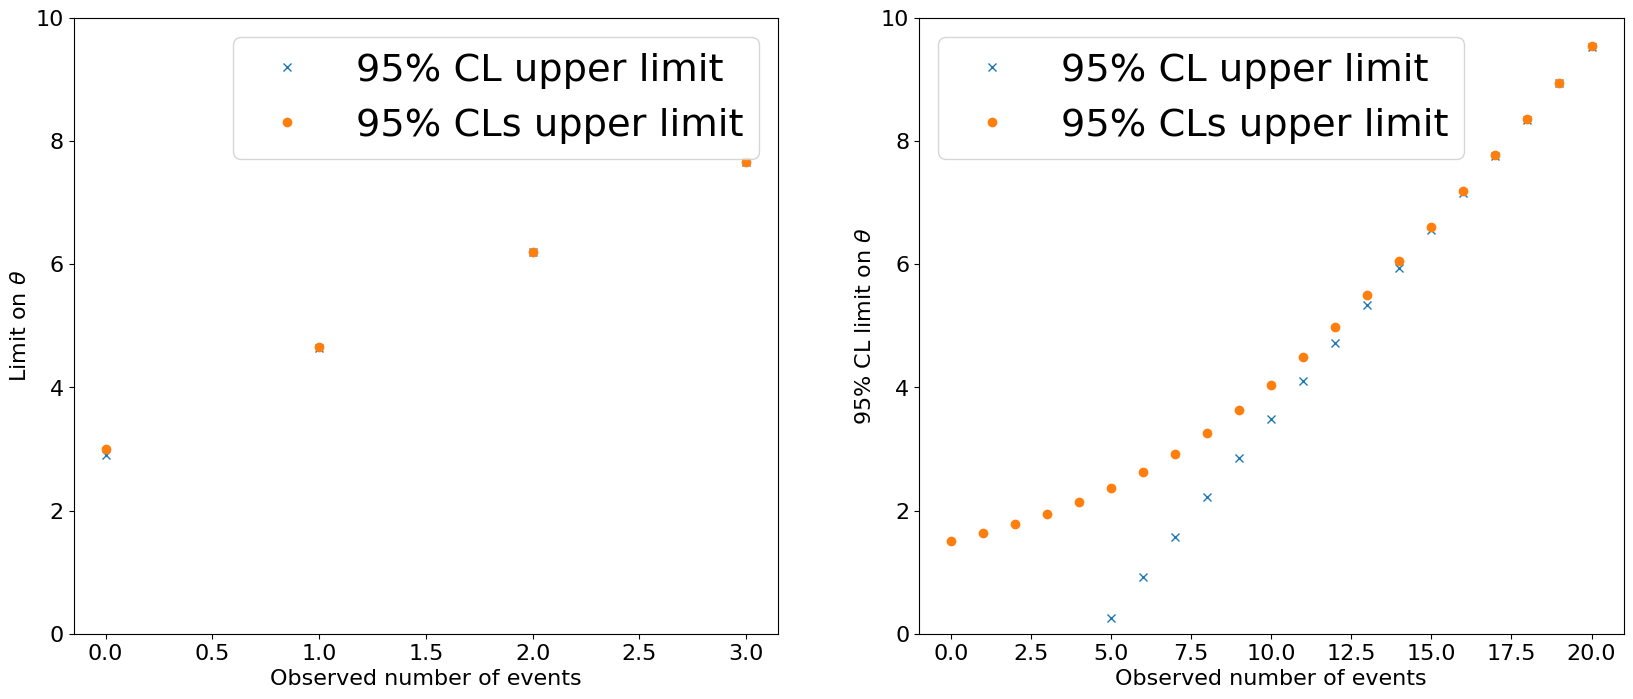

In [7]:
def CLspoiss(obs, mu0):
    mu0cdf = poisson.cdf(obs, mu0)
    root = root_scalar(lambda mu: poisson.cdf(obs, mu)/mu0cdf-0.05, bracket=[0, 20*(max(obs,1))], method='brenth')
    return root.root
    
def get_median_CLs_theta(bkg, signal):
    data = numpy.random.poisson(bkg, size=500)
    limits = numpy.frompyfunc(lambda x: CLspoiss(x, bkg), 1, 1)(data)
    return (numpy.median(limits)-bkg)/signal

pyplot.figure(figsize=(20,8))
pyplot.subplot(1,2,1)
obspoints = list(range(4))
pyplot.plot(obspoints, [(standardCLpoiss(_)-0.1)/1 for _ in obspoints], 'x', label='95% CL upper limit')
pyplot.plot(obspoints, [(CLspoiss(_,0.1)-0.1)/1 for _ in obspoints], 'o', label='95% CLs upper limit')
pyplot.ylabel(r'Limit on $\theta$')
pyplot.xlabel('Observed number of events')
pyplot.ylim(0,10)
pyplot.legend(fontsize='xx-large')

pyplot.subplot(1,2,2)
obspoints = list(range(21))
pyplot.plot(obspoints, [(standardCLpoiss(_)-10)/2 for _ in obspoints], 'x', label='95% CL upper limit')
pyplot.plot(obspoints, [(CLspoiss(_,10)-10)/2 for _ in obspoints], 'o', label='95% CLs upper limit')
pyplot.ylabel(r'95% CL limit on $\theta$')
pyplot.xlabel('Observed number of events')
pyplot.ylim(0,10)
pyplot.legend(fontsize='xx-large')

pyplot.draw()

For the "Good" experiment the effect of the CLs procedure is negligible. For the "Bad" experiment, the CLs upper limit is defined for all potentially observed number of events (unlike the standard confidence interval construction) and the limit on the number of events due to signal can never be better than the best result from the "Good" experiment.  (The plots above show a better limit on $\theta$, because there are twice as many events expected in the "Bad" experiment for the same value of $\theta$.)